In [1]:
import os
# print(os.getcwd())
os.chdir('/root/Affine/Data')

In [2]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10797656865984137718
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15868500378
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 13825481495200702064
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 6.0"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 15868500378
locality {
  bus_id: 2
  numa_node: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 16078871974626442081
physical_device_desc: "device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:d8:00.0, compute capability: 6.0"
]


In [3]:
import sys
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras import callbacks
import time
from keras.applications.resnet50 import ResNet50
import h5py
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
import seaborn as sns

start = time.time()

Using TensorFlow backend.


In [4]:
# DEV = False
# argvs = sys.argv
# argc = len(argvs)


# if argc > 1 and (argvs[1] == "--development" or argvs[1] == "-d"):
#   DEV = True
# if DEV:
#   epochs = 2
# else:
#   epochs = 100

n_epochs = 100
bs = 8

date = '01312019'
train_data_path = './Severe_Accidents/train/'
validation_data_path = './Severe_Accidents/val/'
test_data_path = './Severe_Accidents/test/'
data_annotation_csv_path = './Severe_Accidents/'
model_weights_no_top = '/root/Affine/models/model_weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
save_model_path = '/root/Affine/models/iterations/'
tf_log_path = '/root/Affine/tf-log/new_data/'

In [5]:
from keras import backend as K

tot_num_classes = 38
classes_2 = list(range(1,13))
classes_3 = ['L','R']
classes_4 = ['F','P','B','Y','Z','D']
classes_5 = ['G','M','L','E','H','A']
classes_6 = ['W','N','S']
classes_7 = list(range(1,10))
classes = [classes_2, classes_3, classes_4, classes_5, classes_6, classes_7]

In [6]:
data = pd.read_csv(data_annotation_csv_path + 'Data_Annotation.csv', encoding = 'latin-1')

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def one_hot_categorical(x, classes):
    lb_enc = LabelEncoder().fit(np.array(classes).reshape(-1,1))
    label_encoded = lb_enc.transform(x)
    enc = OneHotEncoder(sparse=False).fit(lb_enc.transform(np.array(classes).reshape(-1,1)).reshape(-1,1))
    enc.transform(label_encoded.reshape(-1,1))
    return enc.transform(label_encoded.reshape(-1,1))

y_2 = one_hot_categorical(data['second_code'],classes_2)    
y_3 = one_hot_categorical(data['third_code'],classes_3)
# Including only side crash code 
# Not including R, C, L
y_4 = one_hot_categorical(data['fourth_code'],classes_4)
y_5 = one_hot_categorical(data['fifth_code'],classes_5)
y_6 = one_hot_categorical(data['sixth_code'],classes_6)
y_7 = one_hot_categorical(data['seventh_code'],classes_7)

# Create multi-label targets
targets = np.concatenate((y_2, y_3, y_4, y_5, y_6, y_7), axis = 1)
image_files = pd.DataFrame(targets)
image_files['filename'] = data['file_name'].apply(lambda x: x+'.jpg')
print('Found ' + str(image_files.shape[0]) + ' annotated images')
image_files.shape

Found 211 annotated images


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

(211, 39)

In [8]:
train_ids = [i.split('/')[-1].strip() for i in glob.glob(train_data_path+'*.jpg')]
train_df = image_files.loc[image_files['filename'].isin(train_ids),:].reset_index(drop = True).drop_duplicates()
print(len(train_ids), train_df.shape)

val_ids = [i.split('/')[-1].strip() for i in glob.glob(validation_data_path+'*.jpg')]
val_df = image_files.loc[image_files['filename'].isin(val_ids),:].reset_index(drop = True).drop_duplicates()
print(len(val_ids), val_df.shape)

test_ids = [i.split('/')[-1].strip() for i in glob.glob(test_data_path+'*.jpg')]
test_df = image_files.loc[image_files['filename'].isin(test_ids),:].reset_index(drop = True).drop_duplicates()
print(len(test_ids), test_df.shape)

166 (166, 39)
22 (22, 39)
21 (21, 39)


In [9]:
def read_data(img_data_gen, base_dir, in_df, path_col = 'filename',
                        y_col = 'targets', batch_size = 8, n_classes = 38):
    
    print(in_df.shape)
    df_gen = img_data_gen.flow_from_dataframe(in_df, base_dir,
                                              x_col = 'filename', y_col= list(range(n_classes)),
                                              has_ext = True, target_size = (512, 512),
                                              color_mode = 'rgb', class_mode = 'other',
                                              batch_size = batch_size)
    
    return df_gen

In [10]:
img_train_gen = ImageDataGenerator(rescale=1/255, rotation_range=10,
                                   width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15)
img_val_gen = ImageDataGenerator(rescale=1/255)
img_test_gen = ImageDataGenerator(rescale=1/255)

train_gen = read_data(img_train_gen, train_data_path,train_df,
                                batch_size = bs, n_classes = tot_num_classes)
val_gen = read_data(img_val_gen,validation_data_path, val_df,
                              batch_size = bs,  n_classes = tot_num_classes)
test_gen = read_data(img_test_gen, test_data_path,test_df,
                               batch_size = bs,  n_classes = tot_num_classes)

(166, 39)
Found 166 images.
(22, 39)
Found 22 images.
(21, 39)
Found 21 images.


In [11]:
#from resnet50 import ResNet50
base_model = ResNet50(include_top=False, weights=None)
base_model.load_weights(model_weights_no_top)

/usr/local/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [16]:
from keras.layers import GlobalAveragePooling2D, Dense

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(tot_num_classes, activation='sigmoid')(x)

In [17]:
from keras.models import Model
model = Model(inputs=base_model.input, outputs = predictions)

In [20]:
from keras import backend as K
import tensorflow as tf

def average_f1(y_true, y_pred):
    
    def f1(y_true, y_pred):
        
        y_true = tf.cast(y_true, tf.float64)
        y_pred = tf.cast(y_pred, tf.float64)
        
        TP = tf.count_nonzero(y_pred * y_true, axis=0, dtype = tf.float64)
        FP = tf.count_nonzero(y_pred * (y_true - 1), axis=0, dtype = tf.float64)
        FN = tf.count_nonzero((y_pred - 1) * y_true, axis=0, dtype = tf.float64)
        
        add_dummy = lambda x: x + K.epsilon()
        precision = TP /  tf.map_fn(add_dummy, (TP + FP))
        recall = TP / tf.map_fn(add_dummy, (TP + FN))
        f1 = 2 * precision * recall / tf.map_fn(add_dummy, (precision + recall))
        
        weights = tf.reduce_sum(y_true, axis=0)
        weights /= tf.reduce_sum(weights)
        return tf.reduce_sum(f1 * weights)
        
    class_2 = f1(y_true[:,:12], y_pred[:,:12])
    class_3 = f1(y_true[:,12:14], y_pred[:,12:14])
    class_4 = f1(y_true[:,14:20], y_pred[:,14:20])
    class_5 = f1(y_true[:,20:26], y_pred[:,20:26])
    class_6 = f1(y_true[:,26:29], y_pred[:,26:29])
    class_7 = f1(y_true[:,29:], y_pred[:,29:])
    
    average_f1 = (class_2 + class_3 + class_4 + class_5 + class_6 + class_7) / 6
    
    return average_f1

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

if not os.path.exists(save_model_path):
  os.mkdir(save_model_path)

model_checkpoint = ModelCheckpoint(save_model_path + date + '_sigmoid_checkpoint_resnet50_'+ str(n_epochs) +'_epoch.model',
                                   monitor='val_average_f1', 
                                   mode = 'max', save_best_only=True, verbose=2)

tb_cb = callbacks.TensorBoard(log_dir=tf_log_path, histogram_freq=0)

early_stopping = EarlyStopping(monitor='val_average_f1', mode = 'max',patience=30, verbose=2)

reduce_lr = ReduceLROnPlateau(monitor='val_average_f1', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=2)

cbks = [tb_cb,model_checkpoint,early_stopping,reduce_lr]

In [16]:
from keras.optimizers import Adam

opt = Adam(lr = 1e-2)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[average_f1,"accuracy"])

In [17]:
history = model.fit_generator(train_gen,steps_per_epoch=24,
                    epochs=n_epochs,validation_data=val_gen,
                    validation_steps=1,callbacks=cbks)

Epoch 1/100
24/24 [==============================] - 49s 2s/step - loss: 0.3760 - average_f1: 0.4820 - acc: 0.8447 - val_loss: 1.6920 - val_average_f1: 0.4349 - val_acc: 0.8947

Epoch 00001: val_average_f1 improved from -inf to 0.43492, saving model to /root/Affine/models/iterations/01312019_sigmoid_checkpoint_resnet50_100_epoch.model
Epoch 2/100
24/24 [==============================] - 32s 1s/step - loss: 0.2810 - average_f1: 0.4745 - acc: 0.8820 - val_loss: 1.5107 - val_average_f1: 0.5429 - val_acc: 0.8816

Epoch 00002: val_average_f1 improved from 0.43492 to 0.54287, saving model to /root/Affine/models/iterations/01312019_sigmoid_checkpoint_resnet50_100_epoch.model
Epoch 3/100
24/24 [==============================] - 45s 2s/step - loss: 0.2741 - average_f1: 0.4787 - acc: 0.8841 - val_loss: 1.1627 - val_average_f1: 0.4569 - val_acc: 0.8684

Epoch 00003: val_average_f1 did not improve from 0.54287
Epoch 4/100
24/24 [==============================] - 46s 2s/step - loss: 0.2775 - averag

In [18]:
history.history.keys()

dict_keys(['val_loss', 'val_average_f1', 'val_acc', 'loss', 'average_f1', 'acc', 'lr'])

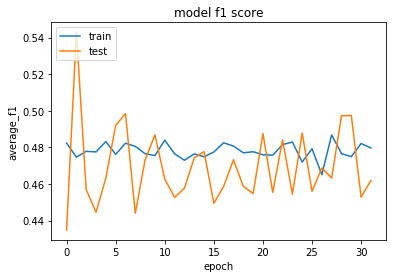

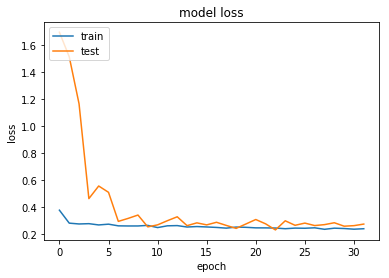

In [19]:
# summarize history for accuracy
plt.plot(history.history['average_f1'])
plt.plot(history.history['val_average_f1'])
plt.title('model f1 score')
plt.ylabel('average_f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
model.save(save_model_path + date + '_sigmoid_model.h5')
model.save_weights(save_model_path + date + '_sigmoid_weights.h5')

#Calculate execution time

end = time.time()
dur = end-start

if dur<60:
    print("Execution Time:",dur,"seconds")
elif dur>60 and dur<3600:
    dur=dur/60
    print("Execution Time:",dur,"minutes")
else:
    dur=dur/(60*60)
    print("Execution Time:",dur,"hours")

Execution Time: 24.53310683965683 minutes


In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [21]:
from keras.models import load_model
model = load_model(save_model_path + date + '_sigmoid_checkpoint_resnet50_'+ str(n_epochs) +'_epoch.model',
                   custom_objects={'average_f1':average_f1})

In [22]:
def model_evaluation(model, generator, folder):
    loss, av_f1, acc = model.evaluate_generator(generator, workers = 1)
    print(folder + ' :')
    print('Loss: ' + str(loss) + '; Average F1: ' + str(av_f1) +'; Accuracy: ' + str(acc))
    
model_evaluation(model, train_gen, 'Train')
model_evaluation(model, val_gen, 'Validation')
model_evaluation(model, test_gen, 'Test')

Train :
Loss: 1.4293133767254382; Average F1: 0.5241824256656542; Accuracy: 0.8833227768001786
Validation :
Loss: 1.6128865046934648; Average F1: 0.5169375783442387; Accuracy: 0.88277513330633
Test :
Loss: 1.2718314556848436; Average F1: 0.4962392464772418; Accuracy: 0.8796992529006231


In [23]:
# Need to add rules for predictions

def get_predictions(model, base_dir, generator, in_df, num_classes = 38, threshold = 0.5, ):
    
    y_true = np.split(np.array(in_df.loc[:,list(range(num_classes))]), [12,14,20,26, 29], axis=1)
    print(np.array(in_df.loc[:,list(range(num_classes))]).shape)
    true = [np.argmax(x, axis = 1) for x in y_true]
    
    y_pred = np.split(model.predict_generator(generator, workers = 1), [12,14,20,26, 29], axis=1)
    print(model.predict_generator(generator).shape)
    pred = [np.argmax(x, axis = 1) for x in y_pred]

    return (true, pred)

train_true, train_pred = get_predictions(model, train_data_path, train_gen, train_df, num_classes = tot_num_classes)
val_true, val_pred = get_predictions(model, validation_data_path, val_gen, val_df, num_classes = tot_num_classes)
test_true, test_pred = get_predictions(model, test_data_path, test_gen, test_df, num_classes = tot_num_classes)

(166, 38)
(166, 38)
(22, 38)
(22, 38)
(21, 38)
(21, 38)


In [24]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [25]:
import sklearn.metrics as metrics

def plot_cm(true, pred, classes, i):
    
    le = LabelEncoder().fit(classes)
    report = metrics.confusion_matrix(le.inverse_transform(true), le.inverse_transform(pred),labels = classes)
    plot_confusion_matrix(report,classes, title = 'col_' + str(i))
    
def plot_cm_all_codes(true, pred, list_classes):
    
    for i in range(len(classes)):
        plot_cm(true[i], pred[i], list_classes[i], i+2)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


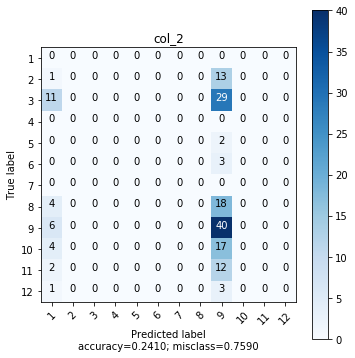

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


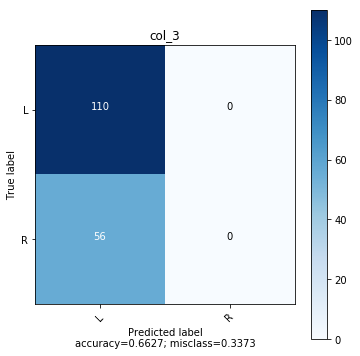

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


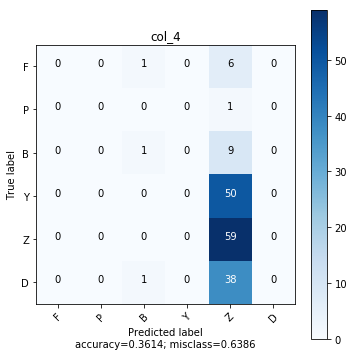

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


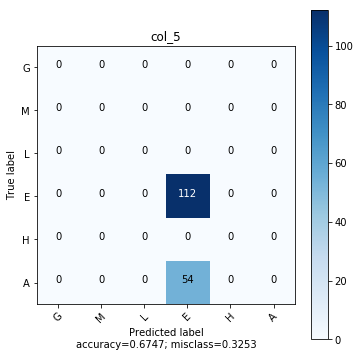

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


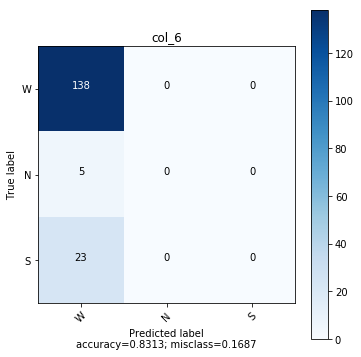

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


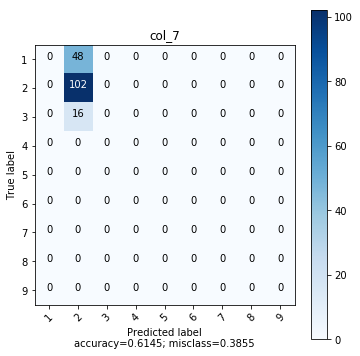

In [26]:
plot_cm_all_codes(train_true, train_pred, classes)

In [27]:
def cm_model_report(writer, folder, true, pred, classes):
    
    print('************' + folder + '*************')
    total_samples = len(true[0])
    start = 0
    m = []
    for i in range(len(classes)):
        
        # Accuracy Metrics
        prf = np.round(metrics.precision_recall_fscore_support(true[i], pred[i], average='weighted')[:-1],4)
        acc = np.round(metrics.accuracy_score(true[i], pred[i]),4)
        metric_list = ['Col'+str(i+2)]
        metric_list.extend(prf)
        metric_list.extend([acc])
        m.append(metric_list)
        print('col_' + str(i+2) + ': ' + str(metric_list))
        
        #Confusion Matrix
        le = LabelEncoder().fit(classes[i])
        report = metrics.confusion_matrix(le.inverse_transform(true[i]), le.inverse_transform(pred[i]),labels = classes[i])
        df = pd.DataFrame(report, columns = classes[i], index = classes[i])
        df.to_excel(writer,sheet_name='CM_' + folder ,startrow=start , startcol=0)   
        start = start + len(classes[i]) + 2
    
    overall_acc = (pd.DataFrame(true) == pd.DataFrame(pred)).all().sum() / total_samples
    print(folder + ' overall accuracy: ', str(np.round(overall_acc *100, 2)))
    metrics_df = pd.DataFrame(m, columns = ['Col','Precision','Recall','F1','Accuracy'])
    metrics_df.to_excel(writer, sheet_name=folder, index = False)
    pd.DataFrame({'Accuracy' : [overall_acc],'Samples':[total_samples]}).to_excel(writer, sheet_name=folder, startrow = 8, index = False)
    print()
    
    return writer


In [28]:
writer = pd.ExcelWriter(save_model_path + date + '_sigmoid_report.xlsx', engine='xlsxwriter')
writer = cm_model_report(writer, 'train', train_true, train_pred, classes)    
writer = cm_model_report(writer, 'val', val_true, val_pred, classes) 
writer = cm_model_report(writer, 'test', test_true, test_pred, classes) 
writer.save()

************train*************
col_2: ['Col2', 0.0809, 0.241, 0.1211, 0.241]
col_3: ['Col3', 0.4391, 0.6627, 0.5282, 0.6627]
col_4: ['Col4', 0.1487, 0.3614, 0.1982, 0.3614]
col_5: ['Col5', 0.4552, 0.6747, 0.5436, 0.6747]
col_6: ['Col6', 0.6911, 0.8313, 0.7548, 0.8313]
col_7: ['Col7', 0.3776, 0.6145, 0.4677, 0.6145]
train overall accuracy:  4.82

************val*************
col_2: ['Col2', 0.0227, 0.0909, 0.0364, 0.0909]
col_3: ['Col3', 0.4649, 0.6818, 0.5528, 0.6818]
col_4: ['Col4', 0.2066, 0.4545, 0.2841, 0.4545]
col_5: ['Col5', 0.405, 0.6364, 0.4949, 0.6364]
col_6: ['Col6', 0.6694, 0.8182, 0.7364, 0.8182]
col_7: ['Col7', 0.405, 0.6364, 0.4949, 0.6364]
val overall accuracy:  4.55

************test*************
col_2: ['Col2', 0.0024, 0.0476, 0.0045, 0.0476]
col_3: ['Col3', 0.4444, 0.6667, 0.5333, 0.6667]
col_4: ['Col4', 0.1111, 0.3333, 0.1667, 0.3333]
col_5: ['Col5', 0.3832, 0.619, 0.4734, 0.619]
col_6: ['Col6', 0.6553, 0.8095, 0.7243, 0.8095]
col_7: ['Col7', 0.3832, 0.619, 0.4734, 0

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `ar